# (Try to) identify signals of gentrification from Airbnb data

In [1]:
import os
import re
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from PlottingFunctions import *

cmap = plt.get_cmap('plasma', 5)  # 5 discrete colors
plot_colors = [cmap(i) for i in range(5)]
plot_colors[4] = 'gold'

### Running for Bristol 

For Bristol there should be 1495 rows in the results. There are 2644 rows in the original listings file, but 1149 of them have no description for the neighbourhood overview or 

In [2]:
city='bristol'
lsoas =  gpd.read_file('../../data/Bristol_LSOAs/Lower_Layer_Super_Output_Areas_2011_(Precise).shp')

### Read in gentrification scores

In [3]:
base_dir = os.path.expanduser(f"../../data/airbnb-{city}/")
gentrication_cat_df = pd.read_csv(base_dir + 'airbnb_gentrification_scores_categorical_01.csv')
gentrication_df = pd.read_csv(base_dir + 'airbnb_gentrification_scores_newprompt_completelistings_01.csv')
niceness_df = pd.read_csv(base_dir + 'airbnb_gentrification_scores_niceness_completelistings_01.csv')

overall_df = gentrication_cat_df
overall_df['niceness_score'] = niceness_df['gentrification_prediction']
overall_df['niceness_explanation'] = niceness_df['explanation']
overall_df['gentrification_num_score'] = gentrication_df['gentrification_prediction']
overall_df['gentrification_num_explanation'] = gentrication_df['explanation']

overall_df['geometry'] = overall_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
overall_gdf = gpd.GeoDataFrame(overall_df, geometry='geometry', crs="EPSG:4326")
overall_gdf = overall_gdf.to_crs(lsoas.crs)
overall_gdf = gpd.sjoin(overall_gdf, lsoas[['LSOA11NM', 'geometry']], how='left', predicate='within')

mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
overall_gdf['gentrification_prediction_code'] = overall_gdf['gentrification_prediction'].map(mapping)

neighbourhoods_scores_gentrification = overall_gdf.groupby("LSOA11NM")["gentrification_prediction_code"].agg(lambda x: pd.Series.mode(x).iloc[0])
neighbourhoods_scores_num_gentrification = overall_gdf.groupby("LSOA11NM")["gentrification_num_score"].agg(
    lambda x: pd.Series.mode(x).iloc[0] if not pd.Series.mode(x).empty else np.nan)
neighbourhoods_scores_niceness = overall_gdf.groupby("LSOA11NM")["niceness_score"].agg(
    lambda x: pd.Series.mode(x).iloc[0] if not pd.Series.mode(x).empty else np.nan)

count = overall_gdf.groupby("LSOA11NM")["gentrification_prediction_code"].count()
count.name = 'Count'
lsoas = lsoas.sort_values(by='LSOA11NM')

lsoas = lsoas.merge(neighbourhoods_scores_gentrification, on='LSOA11NM', how='left')
lsoas = lsoas.merge(neighbourhoods_scores_niceness, on='LSOA11NM', how='left')
lsoas = lsoas.merge(neighbourhoods_scores_num_gentrification, on='LSOA11NM', how='left')
lsoas = lsoas.merge(count, on='LSOA11NM', how='left')

lsoas['gentrification_prediction_code'] = lsoas['gentrification_prediction_code'].fillna(0)

### Read in socio-economic data

In [4]:
indicators = pd.read_csv("../../data/SocioEconomicData/Eng_imputedV3.csv")
indicators_bristol = indicators[indicators['LA_NAME'] =='Bristol, City of'].copy()
indicators_bristol = indicators_bristol.rename(columns={"LSOA": 'LSOA11CD'})
indicators_bristol = indicators_bristol.merge(lsoas[['LSOA11CD', 'gentrification_prediction_code']], on='LSOA11CD', how='left')
indicators_bristol.sort_values(by='gentrification_prediction_code', inplace=True)

In [5]:
del indicators_bristol['Churn_2020']

### Rescale values between 0 and 1

In [6]:
numeric_cols = indicators_bristol.columns
numeric_cols = numeric_cols.drop(['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code'])
indicators_bristol[numeric_cols] = (indicators_bristol[numeric_cols] - indicators_bristol[numeric_cols].min()) / \
                                   (indicators_bristol[numeric_cols].max() - indicators_bristol[numeric_cols].min())

## Run cluster analysis

In [7]:
socioeconomic_vars = indicators_bristol.drop(columns=['LSOA11CD', 'LA_NAME'])

# Scale the variables
scaler = StandardScaler()
scaled_vars = scaler.fit_transform(socioeconomic_vars.iloc[:, 14:])

# Set number of clusters
n_clusters = 5

# Run KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_vars)

# Add the cluster labels to the original dataframe
indicators_bristol['cluster'] = clusters

In [1]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# # Reduce to 2D for visualization
# pca = PCA(n_components=2)
# reduced_data = pca.fit_transform(scaled_vars)

# # Plot
# plt.figure(figsize=(10, 7))
# plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', alpha=0.7)
# plt.colorbar(label='Cluster')
# plt.xlabel('PCA Component 1')
# plt.ylabel('PCA Component 2')
# plt.title('LSOA Clusters Based on Socioeconomic Variables')
# plt.show()

## Plot results

In [8]:
lsoas = lsoas.merge(indicators_bristol[['LSOA11CD', 'cluster']], on='LSOA11CD', how='left')

In [12]:
lsoas

,OBJECTID,LSOA11CD,LSOA11NM,LSOA11LN,MSOA11CD,WARDCD,AREA_M2,PERIMETER_,MI_PRINX,SHAPESTAre,SHAPESTLen,geometry,gentrification_prediction_code,niceness_score,gentrification_num_score,Count,cluster
0,128,E01014601,Bristol 001A,Brentry West,E02003012,E05001988,4.533212e+05,4988.196777,960,4.533212e+05,4988.197012,"POLYGON ((357262.972 179097.828, 357281.008 17...",1.0,3.0,1.0,3.0,1
1,123,E01014602,Bristol 001B,Henbury,E02003012,E05001988,4.198136e+05,3953.294922,875,4.198136e+05,3953.294896,"POLYGON ((356361 179132, 356363.401 179137.225...",0.0,NaN,NaN,NaN,1
2,125,E01014603,Bristol 001C,Brentry East,E02003012,E05001988,5.051932e+05,4036.285889,1222,5.051931e+05,4036.285767,"POLYGON ((358017.116 178958.756, 358003.311 17...",1.0,2.0,NaN,1.0,0
3,127,E01014605,Bristol 001E,Crow Lane,E02003012,E05001988,2.925576e+05,4410.612305,481,2.925576e+05,4410.612147,"POLYGON ((357065.284 178718.814, 357065.409 17...",0.0,NaN,NaN,1.0,1
4,126,E01032516,Bristol 001G,Blaise,E02003012,E05001988,1.468829e+06,7009.566895,73,1.468829e+06,7009.566686,"POLYGON ((355533.5 178546.797, 355543.285 1785...",4.0,NaN,NaN,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,176,E01033369,Bristol 056D,Newtown,E02006889,E05001995,2.993864e+05,4795.576172,1254,2.993864e+05,4795.576403,"POLYGON ((360489.253 173076.402, 360524.491 17...",1.0,2.0,1.0,1.0,4
259,87,E01014568,Bristol 057A,St Marks Road,E02006890,E05001983,1.989857e+05,2925.051270,765,1.989857e+05,2925.051357,"POLYGON ((361149.617 174163.842, 361153 174152...",3.0,4.0,5.0,33.0,4
260,92,E01014569,Bristol 057B,Robertson Road,E02006890,E05001983,1.680303e+05,2900.474365,164,1.680303e+05,2900.474350,"POLYGON ((361455 174499, 361461.344 174479.966...",2.0,3.0,4.0,11.0,4
261,88,E01014570,Bristol 057C,Whitehall,E02006890,E05001983,2.742709e+05,3359.347900,687,2.742709e+05,3359.347877,"POLYGON ((361730.513 174114.264, 361732.602 17...",3.0,3.0,2.0,23.0,1


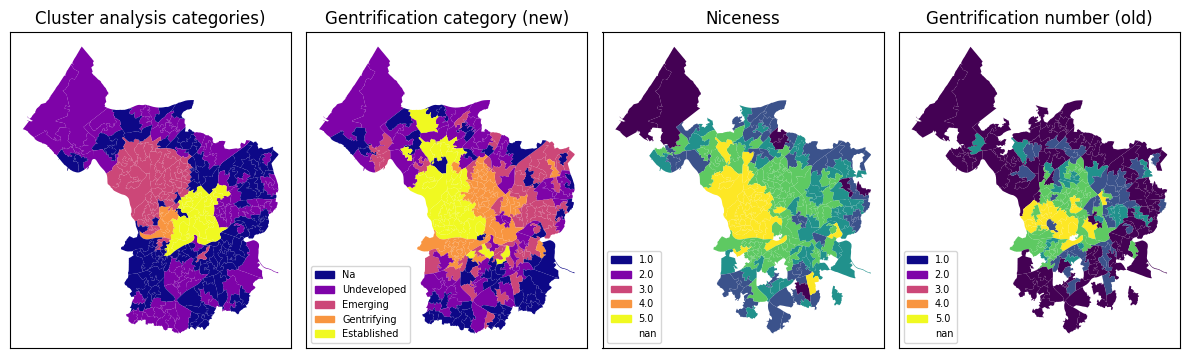

In [11]:
fig, axs = plt.subplots(ncols=4, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1, 1, 1]})  # Ensure equal subplot sizes

cmap = plt.get_cmap('plasma')

# ---- PLOT 1: CATEGORICAL GENTRIFICATION ----
lsoas.plot(ax=axs[0], column='cluster', cmap='plasma')

categories = sorted(lsoas['cluster'].unique())
norm = colors.Normalize(vmin=min(categories), vmax=max(categories))

axs[0].set_title("Cluster analysis categories)")
axs[0].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

# ---- PLOT 3: GENTRIFICATION NUMBER (OLD) ----
lsoas.plot(ax=axs[1], column='gentrification_prediction_code', cmap='plasma')

categories = sorted(lsoas['gentrification_prediction_code'].unique())
norm = colors.Normalize(vmin=min(categories), vmax=max(categories))

legend_patches = [ mpatches.Patch(color=cmap(norm(cat)), label=f'{[k for k, v in mapping.items() if v == cat].pop()}')
    for cat in [0, 1, 2, 3, 4]]

axs[1].legend(handles=legend_patches, loc='lower left', fontsize=7)
axs[1].set_title("Gentrification category (new)")
axs[1].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

# ---- PLOT 2: NICENESS SCORE ----
lsoas.plot(ax=axs[2], column='niceness_score')
axs[2].set_title("Niceness")
axs[2].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

categories = sorted(lsoas['niceness_score'].unique(), key=lambda x: (np.isnan(x), x))
norm = colors.Normalize(vmin=min(categories), vmax=max(categories))

legend_patches = [mpatches.Patch(color=cmap(norm(cat)), label=f'{cat}') for cat in categories]
axs[2].legend(handles=legend_patches, loc='lower left', fontsize=7)

# ---- PLOT 3: GENTRIFICATION NUMBER (OLD) ----
lsoas.plot(ax=axs[3], column='gentrification_num_score')
axs[3].set_title("Gentrification number (old)")
axs[3].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

categories = sorted(lsoas['gentrification_num_score'].unique(), key=lambda x: (np.isnan(x), x))
norm = colors.Normalize(vmin=min(categories), vmax=max(categories))

legend_patches = [mpatches.Patch(color=cmap(norm(cat)), label=f'{cat}') for cat in categories]
axs[3].legend(handles=legend_patches, loc='lower left', fontsize=7)

# Adjust layout
plt.tight_layout()

plt.show()


## Make rose plots

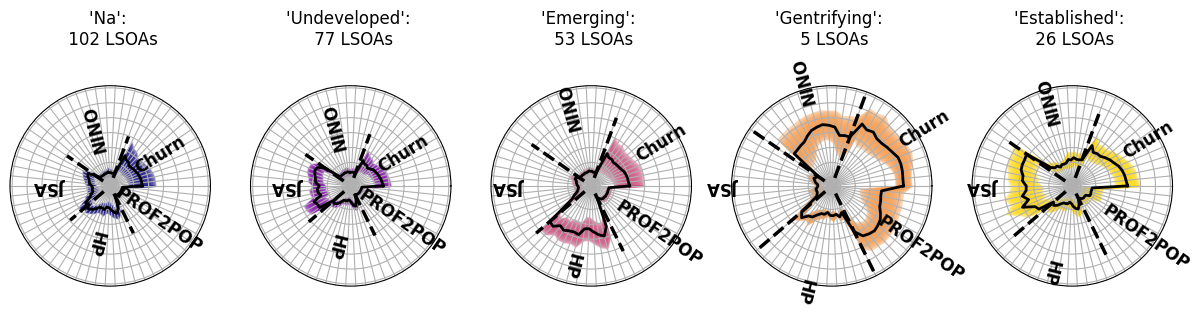

In [10]:
variables = indicators_bristol.columns
to_be_removed = {'LSOA11CD', 'LA_NAME', 'gentrification_prediction_code', 'cluster'}
variables = [item for item in variables if item not in to_be_removed ]

fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=5, nrows=1, figsize=(15,10), sharex=True, sharey=True)

for gentr_class, ax in enumerate(axs.flatten()):
    class_data = indicators_bristol[indicators_bristol['cluster'] == gentr_class]
    if len(class_data) == 0:
        ax.set_axis_off()
    else:
        plot_mean_rose_with_group_labels(ax, class_data, plot_colors[gentr_class],variables)
        key = [k for k, v in mapping.items() if v == gentr_class][0]
        ax.set_title(f"'{key}': \n {len(class_data)} LSOAs", size=12, pad=30)